# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 2048# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["tau21j2"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 366 batches of 2048 samples each, total 749568 samples
Testset consists of 122 batches of 2048 samples each, total 249856 samples


20

In [12]:
X_train

array([[ 0.10093808],
       [ 0.37500465],
       [-0.35312194],
       ...,
       [ 0.11286628],
       [ 0.38153064],
       [ 0.36073804]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['tau21j2'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [02:23<3:53:22, 14.14s/it]


Epoch 10:

Generator training loss: -0.3872015015349362
Discriminator training loss: 0.3637128008193657

Generator validation loss: -0.47217886003314474
Discriminator validation loss: 0.3988601943997086


  2%|█▌                                                                            | 20/1000 [04:48<3:52:40, 14.25s/it]


Epoch 20:

Generator training loss: 0.07273030380815104
Discriminator training loss: 0.3591980880726882

Generator validation loss: -0.15807716182020845
Discriminator validation loss: 0.48127259411772744


  3%|██▎                                                                           | 30/1000 [07:08<3:44:29, 13.89s/it]


Epoch 30:

Generator training loss: 0.006246912483026686
Discriminator training loss: 0.21058648786828166

Generator validation loss: -0.5347941425002989
Discriminator validation loss: 0.42973133408632436


  4%|███                                                                           | 40/1000 [09:27<3:44:00, 14.00s/it]


Epoch 40:

Generator training loss: 0.05542864662193047
Discriminator training loss: 0.041568122413314756

Generator validation loss: -0.7373275190103249
Discriminator validation loss: 0.21767937966057513


  5%|███▉                                                                          | 50/1000 [11:46<3:41:19, 13.98s/it]


Epoch 50:

Generator training loss: 0.34698692021148453
Discriminator training loss: -0.00205819838727402

Generator validation loss: -0.327235110470506
Discriminator validation loss: 0.007083287968330818


  6%|████▋                                                                         | 60/1000 [14:11<3:43:36, 14.27s/it]


Epoch 60:

Generator training loss: 0.32178086205258394
Discriminator training loss: 0.012320861383913787

Generator validation loss: -0.4363782549979257
Discriminator validation loss: 0.04971095490589982


  7%|█████▍                                                                        | 70/1000 [16:33<3:40:51, 14.25s/it]


Epoch 70:

Generator training loss: 0.04190341199785115
Discriminator training loss: 0.01445561092786804

Generator validation loss: -0.8695185687698301
Discriminator validation loss: 0.03523589217210891


  8%|██████▏                                                                       | 80/1000 [18:58<3:41:43, 14.46s/it]


Epoch 80:

Generator training loss: 0.057882941287275544
Discriminator training loss: 0.005214686893022751

Generator validation loss: -0.8805815914615256
Discriminator validation loss: 0.04631069441493906


  9%|███████                                                                       | 90/1000 [21:21<3:36:02, 14.24s/it]


Epoch 90:

Generator training loss: 0.037843082962453346
Discriminator training loss: 0.002443336027135956

Generator validation loss: -0.980325197098685
Discriminator validation loss: 0.05086630080505961


 10%|███████▋                                                                      | 99/1000 [23:30<3:36:46, 14.44s/it]


Epoch 100:

Generator training loss: 0.07357678244328075
Discriminator training loss: 0.0025645747963300167

Generator validation loss: -0.9373653702071456
Discriminator validation loss: 0.028812502333360007

Epoch 100:


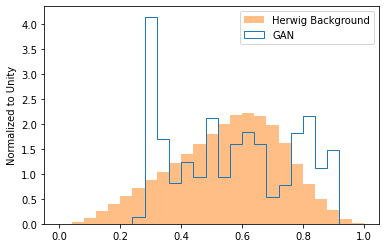

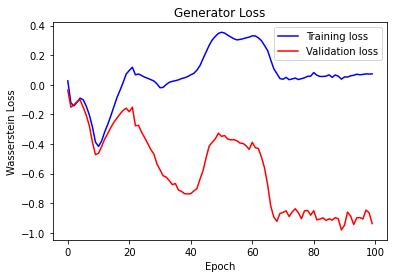

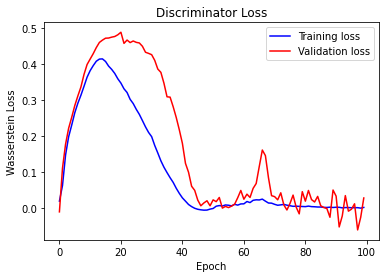

 11%|████████▍                                                                    | 110/1000 [26:05<3:27:28, 13.99s/it]


Epoch 110:

Generator training loss: 0.06137141202642618
Discriminator training loss: 0.0008534352444476496

Generator validation loss: -0.9674628372075128
Discriminator validation loss: 0.044337267086642686


 12%|█████████▏                                                                   | 120/1000 [28:21<3:19:39, 13.61s/it]


Epoch 120:

Generator training loss: 0.05300518660488045
Discriminator training loss: 0.0010960894192429721

Generator validation loss: -0.892453427686066
Discriminator validation loss: -0.03072630566712774


 13%|██████████                                                                   | 130/1000 [30:43<3:25:11, 14.15s/it]


Epoch 130:

Generator training loss: 0.022651047264531134
Discriminator training loss: 0.0005778703851230274

Generator validation loss: -0.9386875639196302
Discriminator validation loss: -0.04356167638735449


 14%|██████████▊                                                                  | 140/1000 [33:03<3:18:55, 13.88s/it]


Epoch 140:

Generator training loss: -0.04001718632306883
Discriminator training loss: 0.0003148405837505454

Generator validation loss: -1.0086919772820395
Discriminator validation loss: -0.02144383979802875


 15%|███████████▌                                                                 | 150/1000 [35:23<3:17:34, 13.95s/it]


Epoch 150:

Generator training loss: -0.09074907810961613
Discriminator training loss: 0.0010235319491261915

Generator validation loss: -1.0699201490058274
Discriminator validation loss: -0.008512276984592823


 16%|████████████▎                                                                | 160/1000 [37:46<3:18:46, 14.20s/it]


Epoch 160:

Generator training loss: -0.12337204850599413
Discriminator training loss: 0.0012266123689704095

Generator validation loss: -1.1213377362391987
Discriminator validation loss: -0.0058040401966790054


 17%|█████████████                                                                | 170/1000 [40:07<3:14:43, 14.08s/it]


Epoch 170:

Generator training loss: -0.09868982318239133
Discriminator training loss: 0.001104674344281844

Generator validation loss: -1.1384186519951116
Discriminator validation loss: 0.008890255747008


 18%|█████████████▊                                                               | 180/1000 [42:27<3:12:00, 14.05s/it]


Epoch 180:

Generator training loss: -0.07763308885156131
Discriminator training loss: -0.00011385521131279482

Generator validation loss: -1.0636326123456485
Discriminator validation loss: 0.0017989746468584434


 19%|██████████████▋                                                              | 190/1000 [44:48<3:10:23, 14.10s/it]


Epoch 190:

Generator training loss: -0.10680843432703631
Discriminator training loss: 0.001045250009272303

Generator validation loss: -1.1078846532790387
Discriminator validation loss: 0.016929582238114308


 20%|███████████████▎                                                             | 199/1000 [46:57<3:09:23, 14.19s/it]


Epoch 200:

Generator training loss: -0.13445698237809978
Discriminator training loss: 0.0010615167283161055

Generator validation loss: -1.1122887994422288
Discriminator validation loss: -0.00684575985002591

Epoch 200:


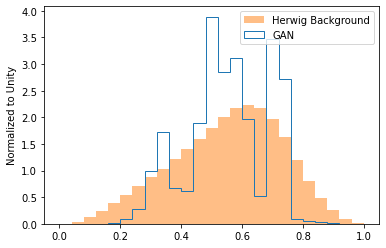

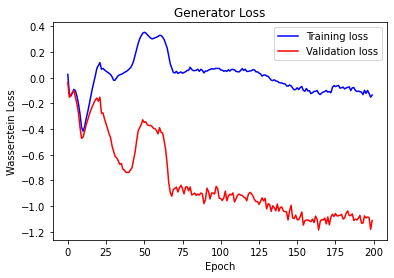

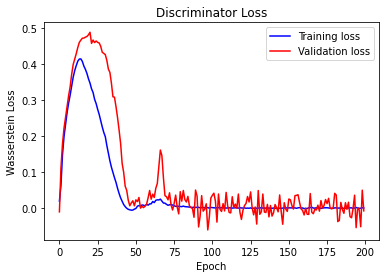

 21%|████████████████▏                                                            | 210/1000 [49:35<3:06:00, 14.13s/it]


Epoch 210:

Generator training loss: -0.11544431514956587
Discriminator training loss: 0.0015896979012101783

Generator validation loss: -1.0893900247870898
Discriminator validation loss: 0.0026872783890242126


 22%|████████████████▉                                                            | 220/1000 [51:56<3:04:36, 14.20s/it]


Epoch 220:

Generator training loss: -0.07126497484545116
Discriminator training loss: -0.0008893307320289492

Generator validation loss: -1.0181274418948127
Discriminator validation loss: -0.020541935807979497


 23%|█████████████████▋                                                           | 230/1000 [54:18<3:03:04, 14.27s/it]


Epoch 230:

Generator training loss: -0.10021543641742624
Discriminator training loss: 0.0013094328365052523

Generator validation loss: -1.0606125329361586
Discriminator validation loss: 0.003498275277155192


 24%|██████████████████▍                                                          | 240/1000 [56:39<2:59:33, 14.18s/it]


Epoch 240:

Generator training loss: -0.117803644490698
Discriminator training loss: 0.0013246995421026132

Generator validation loss: -1.0854487526612204
Discriminator validation loss: -0.010652233840640993


 25%|███████████████████▎                                                         | 250/1000 [59:01<2:57:27, 14.20s/it]


Epoch 250:

Generator training loss: -0.12832500363186083
Discriminator training loss: -0.0006056673035315918

Generator validation loss: -1.12102388358507
Discriminator validation loss: 0.01562644007828537


 26%|███████████████████▌                                                       | 260/1000 [1:01:24<2:55:06, 14.20s/it]


Epoch 260:

Generator training loss: -0.14673624509344987
Discriminator training loss: 0.00022124222672513885

Generator validation loss: -1.177503818371257
Discriminator validation loss: 0.011644352236991657


 27%|████████████████████▎                                                      | 270/1000 [1:03:46<2:54:27, 14.34s/it]


Epoch 270:

Generator training loss: -0.19680788351701256
Discriminator training loss: 0.001079074680127946

Generator validation loss: -1.2407486038129838
Discriminator validation loss: 0.01623893593157428


 28%|█████████████████████                                                      | 280/1000 [1:06:07<2:49:10, 14.10s/it]


Epoch 280:

Generator training loss: -0.2206377608528554
Discriminator training loss: 0.000938818793202287

Generator validation loss: -1.1815815753624088
Discriminator validation loss: -0.0359183153381846


 29%|█████████████████████▊                                                     | 290/1000 [1:08:28<2:46:01, 14.03s/it]


Epoch 290:

Generator training loss: -0.22018923777374413
Discriminator training loss: -3.247973250100819e-05

Generator validation loss: -1.2140821746138275
Discriminator validation loss: 0.01313422145236085


 30%|██████████████████████▍                                                    | 299/1000 [1:10:35<2:44:42, 14.10s/it]


Epoch 300:

Generator training loss: -0.190618668545465
Discriminator training loss: 0.0011395470793785201

Generator validation loss: -1.185026942706499
Discriminator validation loss: -0.019327306515822516

Epoch 300:


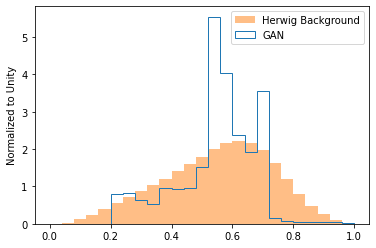

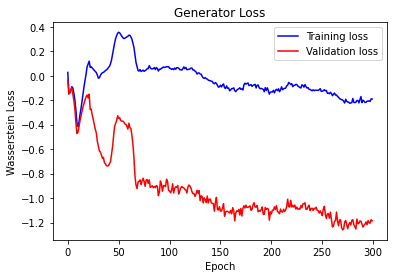

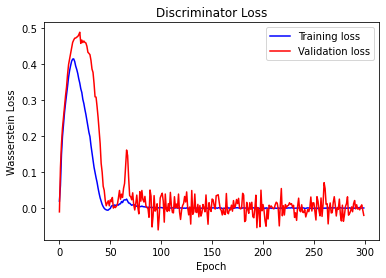

 31%|███████████████████████▎                                                   | 310/1000 [1:13:13<2:41:50, 14.07s/it]


Epoch 310:

Generator training loss: -0.2158123767766796
Discriminator training loss: 9.239747918390159e-05

Generator validation loss: -1.2212583803739705
Discriminator validation loss: 0.005559314234963748


 32%|████████████████████████                                                   | 320/1000 [1:15:32<2:37:54, 13.93s/it]


Epoch 320:

Generator training loss: -0.23951959198778444
Discriminator training loss: 0.0011760029769579713

Generator validation loss: -1.23048071587672
Discriminator validation loss: -0.001108649326106686


 33%|████████████████████████▊                                                  | 330/1000 [1:17:51<2:35:00, 13.88s/it]


Epoch 330:

Generator training loss: -0.2791681759914414
Discriminator training loss: -0.00015514667396471183

Generator validation loss: -1.2712692227519926
Discriminator validation loss: 0.017933820788681765


 34%|█████████████████████████▌                                                 | 340/1000 [1:20:10<2:33:35, 13.96s/it]


Epoch 340:

Generator training loss: -0.2517434640741739
Discriminator training loss: -0.0005435491248503578

Generator validation loss: -1.2561044399855568
Discriminator validation loss: 0.011797428083153762


 35%|██████████████████████████▎                                                | 350/1000 [1:22:29<2:31:03, 13.94s/it]


Epoch 350:

Generator training loss: -0.28060504598695724
Discriminator training loss: 0.0014389530171912488

Generator validation loss: -1.281557931274664
Discriminator validation loss: 0.006620215252518929


 36%|███████████████████████████                                                | 360/1000 [1:24:49<2:28:35, 13.93s/it]


Epoch 360:

Generator training loss: -0.2784411563980775
Discriminator training loss: 0.0005909438037613783

Generator validation loss: -1.3114465807305007
Discriminator validation loss: 0.02301835013194712


 37%|███████████████████████████▊                                               | 370/1000 [1:27:11<2:30:03, 14.29s/it]


Epoch 370:

Generator training loss: -0.247244527675415
Discriminator training loss: -0.0003383939322946171

Generator validation loss: -1.2554376008080654
Discriminator validation loss: -0.027483678254924836


 38%|████████████████████████████▌                                              | 380/1000 [1:29:35<2:27:05, 14.24s/it]


Epoch 380:

Generator training loss: -0.2749332944796385
Discriminator training loss: 0.0003693846828111637

Generator validation loss: -1.3052446685853552
Discriminator validation loss: -0.008947996071732573


 39%|█████████████████████████████▎                                             | 390/1000 [1:31:57<2:24:02, 14.17s/it]


Epoch 390:

Generator training loss: -0.30450497189017595
Discriminator training loss: 0.0014460046594237108

Generator validation loss: -1.310522885596166
Discriminator validation loss: -0.006486120752104726


 40%|█████████████████████████████▉                                             | 399/1000 [1:34:03<2:21:10, 14.09s/it]


Epoch 400:

Generator training loss: -0.28928405099390636
Discriminator training loss: 0.0009257596555143523

Generator validation loss: -1.3266887625709909
Discriminator validation loss: 0.013169330842010524

Epoch 400:


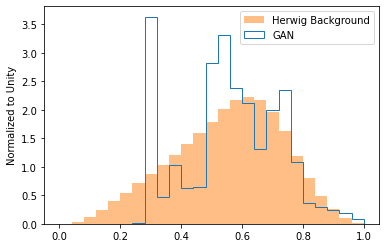

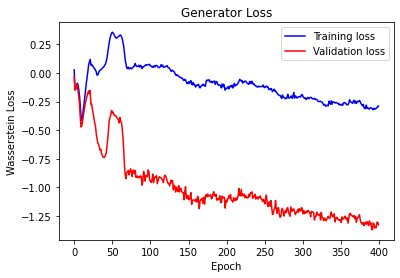

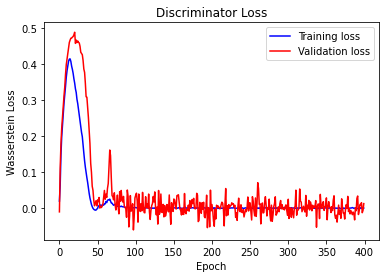

 41%|██████████████████████████████▋                                            | 410/1000 [1:36:40<2:18:55, 14.13s/it]


Epoch 410:

Generator training loss: -0.2762237812896244
Discriminator training loss: 0.0014214221089906593

Generator validation loss: -1.2941934994009674
Discriminator validation loss: -0.0014236598138670728


 42%|███████████████████████████████▌                                           | 420/1000 [1:39:01<2:16:30, 14.12s/it]


Epoch 420:

Generator training loss: -0.28939465807923853
Discriminator training loss: 0.0002560257548043285

Generator validation loss: -1.3004504139306114
Discriminator validation loss: -0.010780396504131085


 43%|████████████████████████████████▎                                          | 430/1000 [1:41:21<2:12:54, 13.99s/it]


Epoch 430:

Generator training loss: -0.4020617828994501
Discriminator training loss: 0.0008723129648223832

Generator validation loss: -1.4111098168326206
Discriminator validation loss: -0.010649216570080349


 44%|█████████████████████████████████                                          | 440/1000 [1:43:42<2:12:45, 14.22s/it]


Epoch 440:

Generator training loss: -0.36608958781742656
Discriminator training loss: 0.0012146377892409486

Generator validation loss: -1.3951195283014266
Discriminator validation loss: -0.018573970551083445


 45%|█████████████████████████████████▊                                         | 450/1000 [1:46:04<2:08:48, 14.05s/it]


Epoch 450:

Generator training loss: -0.3821092147807606
Discriminator training loss: 0.0006564922327701513

Generator validation loss: -1.4084827841305343
Discriminator validation loss: -0.012730424139351913


 46%|██████████████████████████████████▌                                        | 460/1000 [1:48:25<2:07:07, 14.13s/it]


Epoch 460:

Generator training loss: -0.3866404001830054
Discriminator training loss: 0.0011971190119284025

Generator validation loss: -1.4007588517470437
Discriminator validation loss: -0.03292242365938871


 47%|███████████████████████████████████▎                                       | 470/1000 [1:50:46<2:04:51, 14.14s/it]


Epoch 470:

Generator training loss: -0.4084003302243238
Discriminator training loss: 0.001224703734954202

Generator validation loss: -1.42973456519549
Discriminator validation loss: 0.0005353372132690236


 48%|████████████████████████████████████                                       | 480/1000 [1:53:06<2:01:18, 14.00s/it]


Epoch 480:

Generator training loss: -0.3688089370401831
Discriminator training loss: 4.8694731762861425e-05

Generator validation loss: -1.4081097118190078
Discriminator validation loss: -0.014938794028970076


 49%|████████████████████████████████████▊                                      | 490/1000 [1:55:27<1:58:27, 13.94s/it]


Epoch 490:

Generator training loss: -0.36099255166418565
Discriminator training loss: 0.0006703437730119547

Generator validation loss: -1.4249996279106765
Discriminator validation loss: 0.0027040723376319607


 50%|█████████████████████████████████████▍                                     | 499/1000 [1:57:34<1:57:35, 14.08s/it]


Epoch 500:

Generator training loss: -0.36951749303627535
Discriminator training loss: -0.0001683391957908622

Generator validation loss: -1.4293675921002373
Discriminator validation loss: -0.006384478140523138

Epoch 500:


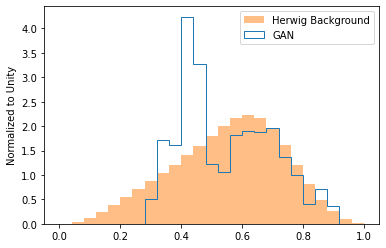

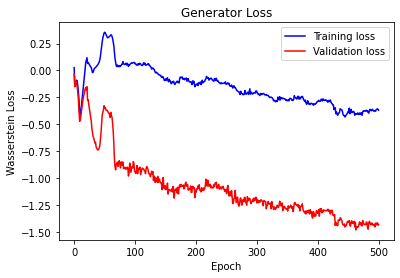

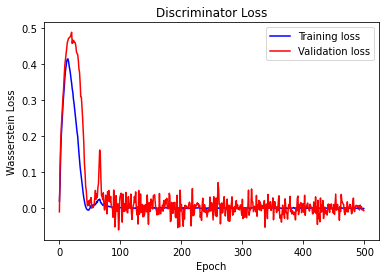

 51%|██████████████████████████████████████▎                                    | 510/1000 [2:00:09<1:54:16, 13.99s/it]


Epoch 510:

Generator training loss: -0.4393969656176906
Discriminator training loss: -0.0009608160225552687

Generator validation loss: -1.4880545324966556
Discriminator validation loss: -0.010024020585377479


 52%|███████████████████████████████████████                                    | 520/1000 [2:02:30<1:52:26, 14.06s/it]


Epoch 520:

Generator training loss: -0.4563950357215652
Discriminator training loss: 0.00022446815048289087

Generator validation loss: -1.5272694542759755
Discriminator validation loss: 0.004833164709050267


 53%|███████████████████████████████████████▊                                   | 530/1000 [2:04:53<1:51:43, 14.26s/it]


Epoch 530:

Generator training loss: -0.465803257266029
Discriminator training loss: 0.003330982095276291

Generator validation loss: -1.5430507972592213
Discriminator validation loss: 0.019694893724680116


 54%|████████████████████████████████████████▌                                  | 540/1000 [2:07:12<1:46:03, 13.83s/it]


Epoch 540:

Generator training loss: -0.4598573432431195
Discriminator training loss: -0.0009654003179004249

Generator validation loss: -1.5276120148721288
Discriminator validation loss: -0.006946559113948454


 55%|█████████████████████████████████████████▎                                 | 550/1000 [2:09:33<1:45:34, 14.08s/it]


Epoch 550:

Generator training loss: -0.5617666088981055
Discriminator training loss: 0.0026740850225726973

Generator validation loss: -1.613781403322689
Discriminator validation loss: 0.01294159112578319


 56%|██████████████████████████████████████████                                 | 560/1000 [2:11:58<1:45:30, 14.39s/it]


Epoch 560:

Generator training loss: -0.6006530112093263
Discriminator training loss: -0.0007997686956951724

Generator validation loss: -1.6531513167209313
Discriminator validation loss: -0.006500410785758772


 57%|██████████████████████████████████████████▋                                | 570/1000 [2:14:19<1:40:47, 14.06s/it]


Epoch 570:

Generator training loss: -0.5667728892441004
Discriminator training loss: -0.0017486079202683725

Generator validation loss: -1.6471131932540017
Discriminator validation loss: 0.0038790469958168284


 58%|███████████████████████████████████████████▌                               | 580/1000 [2:16:37<1:36:40, 13.81s/it]


Epoch 580:

Generator training loss: -0.5485571060187179
Discriminator training loss: 0.00032376353958538285

Generator validation loss: -1.6056046886522262
Discriminator validation loss: -0.007117338972312743


 59%|████████████████████████████████████████████▎                              | 590/1000 [2:18:59<1:37:10, 14.22s/it]


Epoch 590:

Generator training loss: -0.6418808359917396
Discriminator training loss: 0.0013927877281618792

Generator validation loss: -1.6995085800280336
Discriminator validation loss: 0.007662478388231305


 60%|████████████████████████████████████████████▉                              | 599/1000 [2:21:05<1:33:16, 13.96s/it]


Epoch 600:

Generator training loss: -0.6268323366759253
Discriminator training loss: 0.00018720305725054078

Generator validation loss: -1.6802506427295874
Discriminator validation loss: 0.0002271813173734461

Epoch 600:


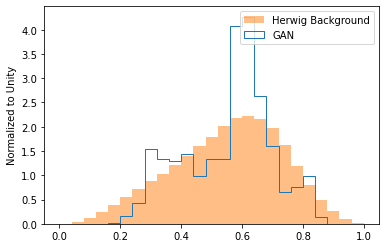

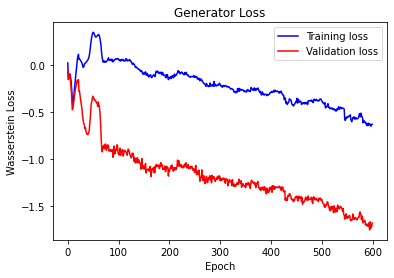

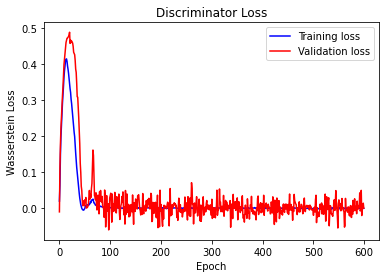

 61%|█████████████████████████████████████████████▊                             | 610/1000 [2:23:39<1:30:44, 13.96s/it]


Epoch 610:

Generator training loss: -0.6030801985758901
Discriminator training loss: 0.00080222607242523

Generator validation loss: -1.6525548305667814
Discriminator validation loss: 0.009344245641602997


 62%|██████████████████████████████████████████████▌                            | 620/1000 [2:25:59<1:28:33, 13.98s/it]


Epoch 620:

Generator training loss: -0.5797878796122765
Discriminator training loss: 0.0016773680041724168

Generator validation loss: -1.6979732396172695
Discriminator validation loss: 0.012619057452672573


 63%|███████████████████████████████████████████████▎                           | 630/1000 [2:28:20<1:27:51, 14.25s/it]


Epoch 630:

Generator training loss: -0.6326777062129453
Discriminator training loss: 0.0007098532638019854

Generator validation loss: -1.6496057060898328
Discriminator validation loss: -0.01313624868587377


 64%|████████████████████████████████████████████████                           | 640/1000 [2:30:46<1:26:40, 14.44s/it]


Epoch 640:

Generator training loss: -0.6559518280902196
Discriminator training loss: 0.00020063035194876558

Generator validation loss: -1.7463235513108675
Discriminator validation loss: 0.007539217242232494


 65%|████████████████████████████████████████████████▊                          | 650/1000 [2:33:08<1:22:45, 14.19s/it]


Epoch 650:

Generator training loss: -0.7199268003956216
Discriminator training loss: 0.0013945707933198917

Generator validation loss: -1.7881832826332968
Discriminator validation loss: -0.01730400473013001


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [2:35:30<1:19:59, 14.12s/it]


Epoch 660:

Generator training loss: -0.8299459192922206
Discriminator training loss: 0.0030150613167249695

Generator validation loss: -1.808779089177241
Discriminator validation loss: -0.009604846636886846


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [2:37:52<1:18:29, 14.27s/it]


Epoch 670:

Generator training loss: -0.9476047409036772
Discriminator training loss: 0.006406023861637436

Generator validation loss: -2.0104945946912296
Discriminator validation loss: 0.009027405654855042


 68%|███████████████████████████████████████████████████                        | 680/1000 [2:40:15<1:16:43, 14.39s/it]


Epoch 680:

Generator training loss: -1.114656424261833
Discriminator training loss: 0.006405748195411533

Generator validation loss: -2.0897973013705893
Discriminator validation loss: -0.013002949085737365


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [2:42:38<1:14:08, 14.35s/it]


Epoch 690:

Generator training loss: -1.18295526211379
Discriminator training loss: 0.0021202015375333286

Generator validation loss: -2.139171148909897
Discriminator validation loss: 0.017716864169027548


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [2:44:44<1:10:17, 14.01s/it]


Epoch 700:

Generator training loss: -1.2474168076541254
Discriminator training loss: 0.0043358291200087965

Generator validation loss: -2.140958318944837
Discriminator validation loss: -0.025689793935763178

Epoch 700:


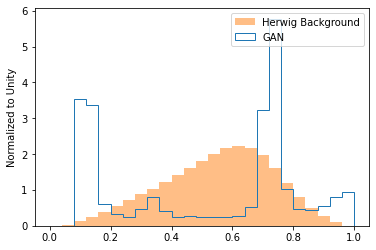

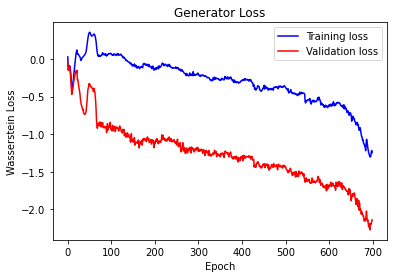

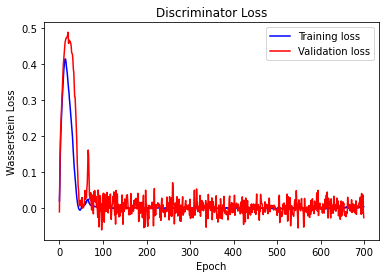

 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [2:47:17<1:07:01, 13.87s/it]


Epoch 710:

Generator training loss: -1.3551397186810854
Discriminator training loss: 0.0010298306840197426

Generator validation loss: -2.2482241177168047
Discriminator validation loss: 0.0002825023364523792


 72%|██████████████████████████████████████████████████████                     | 720/1000 [2:49:36<1:05:01, 13.93s/it]


Epoch 720:

Generator training loss: -1.416964813334043
Discriminator training loss: 0.002006904855572499

Generator validation loss: -2.291591609110598
Discriminator validation loss: -0.023506870352544777


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [2:51:55<1:02:18, 13.84s/it]


Epoch 730:

Generator training loss: -1.4927534047371702
Discriminator training loss: 0.008850339843544542

Generator validation loss: -2.3628326517636657
Discriminator validation loss: -0.02575146606321767


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [2:52:36<1:01:24, 13.80s/it]

In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z